# V8


In [1]:
# --- Step 1: Mount Google Drive (optional) ---
from google.colab import drive
drive.mount('/content/drive')  # Uncomment if dataset is in Google Drive

Mounted at /content/drive


In [2]:
# --- Step 2: Install dependencies ---
!pip install pillow tqdm pytesseract easyocr numpy opencv-python
!apt-get install -y tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 26.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [3]:
import json
import os
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import pytesseract
import easyocr

In [ ]:
# Read labels from classes.txt
def read_classes(dataset_root: Path):
    classes_file = dataset_root / 'classes.txt'
    if classes_file.exists():
        with classes_file.open('r', encoding='utf-8') as f:
            return [line.strip() for line in f if line.strip()]
    return None

In [4]:
def yolo_to_pixels(yolo_line, img_w, img_h):
    parts = yolo_line.strip().split()
    cls = int(float(parts[0]))
    x_c, y_c, w, h = map(float, parts[1:5])
    x_min = (x_c - w/2) * img_w
    y_min = (y_c - h/2) * img_h
    x_max = (x_c + w/2) * img_w
    y_max = (y_c + h/2) * img_h
    return int(x_min), int(y_min), int(x_max), int(y_max), cls

In [11]:
def pixels_to_1000(bbox, img_w, img_h):
    return [int(1000*bbox[0]/img_w), int(1000*bbox[1]/img_h), int(1000*bbox[2]/img_w), int(1000*bbox[3]/img_h)]

def run_ocr(image_path, engine='tesseract'):
    if engine == 'tesseract':
        img = Image.open(image_path).convert('RGB')
        data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
        words, boxes = [], []
        for i, text in enumerate(data['text']):
            if text.strip():
                words.append(text.strip())
                # Tesseract provides boxes as [left, top, width, height]
                boxes.append([data['left'][i], data['top'][i], data['left'][i]+data['width'][i], data['top'][i]+data['height'][i]])
        return words, boxes
    elif engine == 'easyocr':
        reader = easyocr.Reader(['en'], gpu=True)
        results = reader.readtext(str(image_path))
        words, boxes = [], []
        for bbox, text, conf in results:
            if text.strip():
                # EasyOCR provides boxes as [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
                # We'll convert it to [x_min, y_min, x_max, y_max]
                xs, ys = [p[0] for p in bbox], [p[1] for p in bbox]
                boxes.append([int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))])
                words.append(text.strip())
        return words, boxes
    else:
        return [], []

## Train V8

In [9]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "train_v8.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [12]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/train_v8')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 282/282 [19:35<00:00,  4.17s/it]

Wrote 282 entries to /content/drive/MyDrive/last_invoice/train_v8.jsonl
Conversion complete.


/content/drive/MyDrive/train_v8/images/t-10_jpg.rf.067946f012c103cecfe372ecc18c3999.jpg


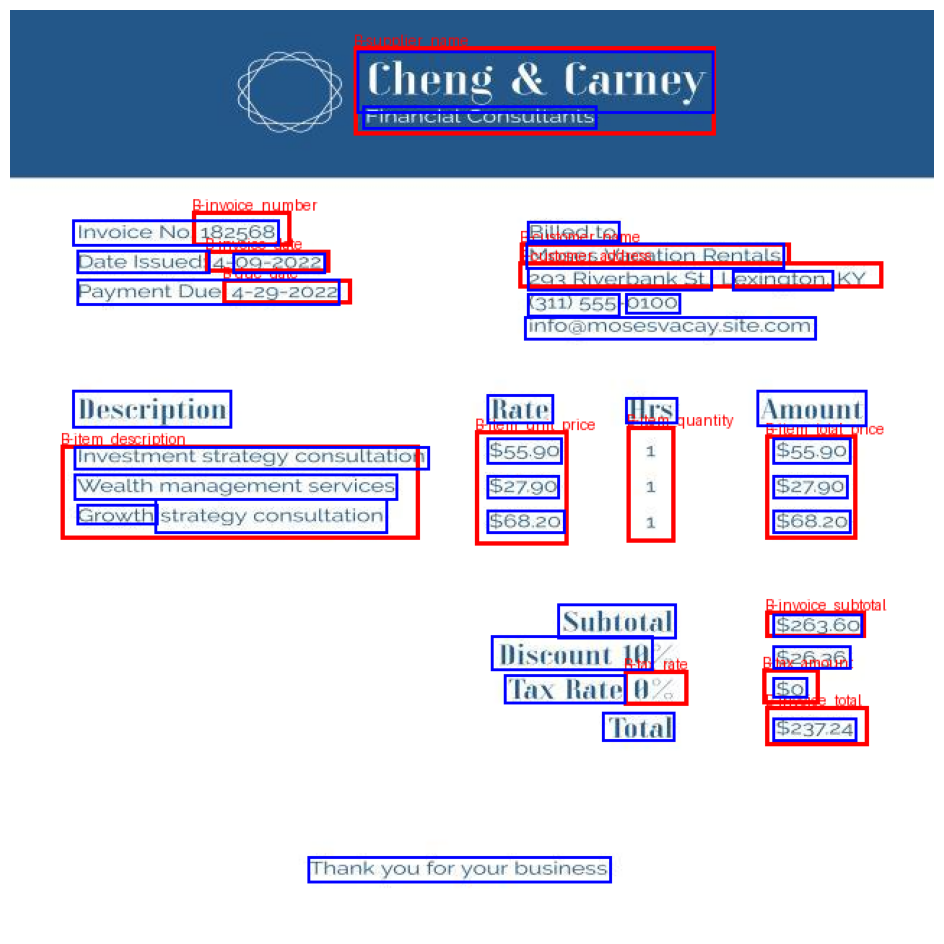

In [13]:
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path # Import Path

# Paths
json_path = "/content/drive/MyDrive/last_invoice/train_v8.jsonl"

# Load JSONL data
data = []
with open(json_path, "r", encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Pick an example (assuming the image path in the JSONL is relative to the dataset root)
# You might need to adjust the image_path here based on how the image paths are stored in your JSONL
example = data[10]  # change index if needed
img_relative_path = example["image"]
# Construct the full image path - assuming the relative path is from the dataset root
# You might need to adjust this based on your specific file structure
print(img_relative_path)
img_path = img_relative_path


img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

# Draw region bboxes (Red)
for bbox, label in zip(example["region_bboxes"], example["region_labels"]):
    # Scale the bounding boxes from 1000 back to pixel coordinates
    x1, y1, x2, y2 = [int(b * img.size[0] / 1000) if i % 2 == 0 else int(b * img.size[1] / 1000) for i, b in enumerate(bbox)]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    draw.text((x1, y1 - 10), label, fill="red")

# Draw token bboxes (Blue)
if "token_bboxes" in example:
    for bbox, token in zip(example["token_bboxes"], example["token_words"]):
        # Scale the bounding boxes from 1000 back to pixel coordinates
        x1, y1, x2, y2 = [int(b * img.size[0] / 1000) if i % 2 == 0 else int(b * img.size[1] / 1000) for i, b in enumerate(bbox)]
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        # Optionally draw token text
        # draw.text((x1, y1 - 10), token, fill="blue")


# Show result
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()

In [14]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/train_v8.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/train_v8.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/train_v8.jsonl


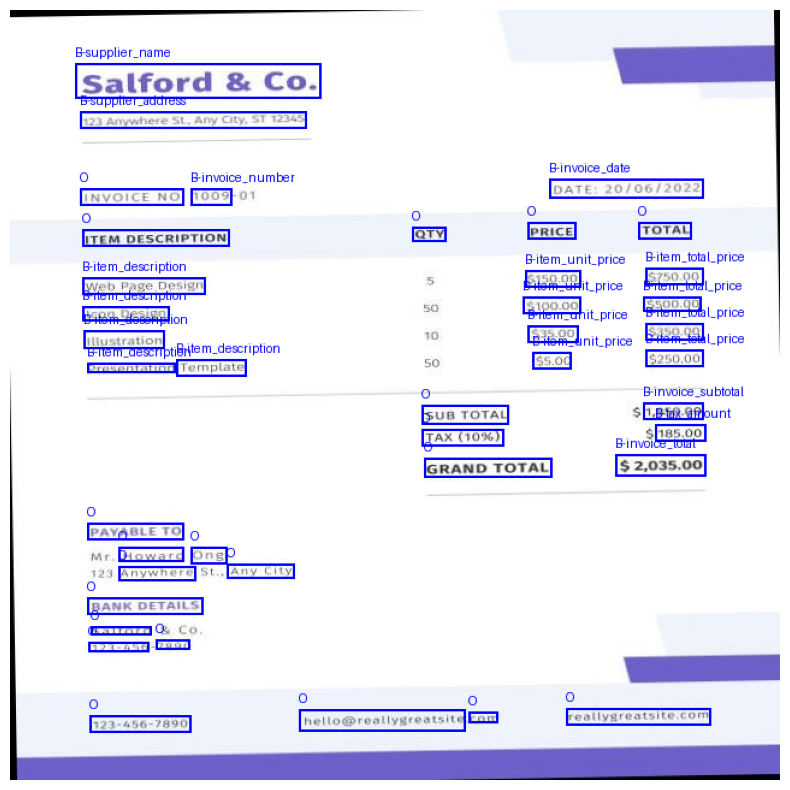

In [15]:
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from pathlib import Path



# Paths
annotations_path = "/content/drive/MyDrive/last_invoice/dataset/train_v8.jsonl"



# Load annotations
with open(annotations_path, "r", encoding='utf-8') as f:
    annotations_data = json.load(f)

# Pick example
example_jsonl = annotations_data[0]  # change index as needed
img_relative_path = example_jsonl["image"]

# Define the original dataset root to construct the correct image path
original_dataset_root = Path('/content/drive/MyDrive/train_v8')  # Change to your original dataset root
img_path = original_dataset_root / Path(img_relative_path).relative_to(original_dataset_root)


# Load image
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

# Find matching annotation
example_annotation = next((entry for entry in annotations_data if entry["id"] == example_jsonl["id"]), None)

if example_annotation:
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    seen_boxes = set()

    for bbox_1000, label in zip(example_annotation["token_bboxes"], example_annotation["token_labels"]):
        # Remove this check to draw all token bounding boxes
        # if label.lower() == "extra":
        #     continue

        # Convert coordinates
        x1 = int(bbox_1000[0] * img.width / 1000)
        y1 = int(bbox_1000[1] * img.height / 1000)
        x2 = int(bbox_1000[2] * img.width / 1000)
        y2 = int(bbox_1000[3] * img.height / 1000)

        box_tuple = (x1, y1, x2, y2, label)
        if box_tuple in seen_boxes:
            continue
        seen_boxes.add(box_tuple)

        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, max(y1 - 15, 0)), label, fill="blue", font=font) # Optionally draw token label


    # Show image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print(f"No annotations found for image ID: {example_jsonl['id']}")

## Test V8

In [16]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "test_v8.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [17]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/test_v8')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 29/29 [02:29<00:00,  5.17s/it]

Wrote 29 entries to /content/drive/MyDrive/last_invoice/test_v8.jsonl
Conversion complete.


In [22]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/test_v8.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/test_v8.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/test_v8.jsonl


## Valid_v8


In [23]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "valid_v8.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [24]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/valid_v8')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 29/29 [02:33<00:00,  5.30s/it]

Wrote 29 entries to /content/drive/MyDrive/last_invoice/valid_v8.jsonl
Conversion complete.


In [25]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/valid_v8.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/valid_v8.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/valid_v8.jsonl


# V7

## Train_v7

In [26]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "train_v7.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [27]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/train_v7')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 293/293 [21:05<00:00,  4.32s/it]

Wrote 293 entries to /content/drive/MyDrive/last_invoice/train_v7.jsonl
Conversion complete.


In [28]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/train_v7.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/train_v7.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/train_v7.jsonl


## Test_v7

In [29]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "test_v7.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [30]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/test_v7')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 4/4 [00:18<00:00,  4.58s/it]

Wrote 4 entries to /content/drive/MyDrive/last_invoice/test_v7.jsonl
Conversion complete.


In [31]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/test_v7.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/test_v7.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/test_v7.jsonl


## Valid_v7

In [32]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "valid_v7.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [33]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/valid_v7')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 44/44 [03:50<00:00,  5.24s/it]

Wrote 44 entries to /content/drive/MyDrive/last_invoice/valid_v7.jsonl
Conversion complete.


In [34]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/valid_v7.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/valid_v7.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/valid_v7.jsonl


# V6

## Train_v6

In [35]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "train_v6.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [36]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/train_v6')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 121/121 [08:40<00:00,  4.30s/it]

Wrote 121 entries to /content/drive/MyDrive/last_invoice/train_v6.jsonl
Conversion complete.


In [37]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/train_v6.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/train_v6.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/train_v6.jsonl


## Test_v6

In [38]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "test_v6.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [39]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/test_v6')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 10/10 [00:46<00:00,  4.66s/it]

Wrote 10 entries to /content/drive/MyDrive/last_invoice/test_v6.jsonl
Conversion complete.


In [40]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/test_v6.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/test_v6.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/test_v6.jsonl


## Valid_v6

In [41]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "valid_v6.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [42]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/valid_v6')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 25/25 [02:22<00:00,  5.71s/it]

Wrote 25 entries to /content/drive/MyDrive/last_invoice/valid_v6.jsonl
Conversion complete.


In [43]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/valid_v6.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/valid_v6.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/valid_v6.jsonl


# V5

## Train_v5

In [44]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "train_v5.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [45]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/train_v5')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 82/82 [06:18<00:00,  4.61s/it]

Wrote 82 entries to /content/drive/MyDrive/last_invoice/train_v5.jsonl
Conversion complete.


In [46]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/train_v5.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/train_v5.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/train_v5.jsonl


In [48]:
import json
from datasets import Dataset

# Load your annotated dataset
with open("/content/drive/MyDrive/last_invoice/dataset/test_v6.jsonl", "r") as f:
    data = json.load(f)

# Inspect one example
print(data[0])


{'id': 't-20_jpg.rf.8698f3c76c3a53e0601087146b6ae479', 'image': '/content/drive/MyDrive/test_v6/images/t-20_jpg.rf.8698f3c76c3a53e0601087146b6ae479.jpg', 'region_bboxes': [[448, 454, 487, 540], [64, 281, 435, 303], [570, 140, 706, 159], [501, 281, 931, 300], [503, 262, 848, 281], [632, 115, 710, 134], [812, 456, 876, 534], [56, 257, 309, 284], [123, 451, 364, 539], [614, 451, 675, 537], [820, 623, 867, 648], [787, 660, 867, 693], [560, 657, 592, 696], [784, 743, 870, 778]], 'region_labels': ['B-item_quantity', 'B-customer_address', 'B-invoice_date', 'B-supplier_address', 'B-supplier_name', 'B-invoice_number', 'B-item_total_price', 'B-customer_name', 'B-item_description', 'B-item_unit_price', 'B-invoice_subtotal', 'B-tax_amount', 'B-tax_rate', 'B-invoice_total'], 'token_words': ['QUOTE', 'Quote', '152465', 'Date', '/12/20xX', 'Customer', '0463', 'TO', 'FROM', 'Wallace', 'Allberg HQ', 'Whatzclean', 'Cleaning', 'Services', '1887', 'Tomato', 'Lune', 'Lafayette', '4777', 'Green', 'Hill', 'R

## Valid_v5

In [49]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "valid_v5.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [50]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/valid_v5')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 48/48 [03:47<00:00,  4.74s/it]

Wrote 48 entries to /content/drive/MyDrive/last_invoice/valid_v5.jsonl
Conversion complete.


In [51]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/valid_v5.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/valid_v5.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/valid_v5.jsonl


# V4

## Train_v4

In [52]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "train_v4.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [53]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/train_v4')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 103/103 [06:55<00:00,  4.04s/it]

Wrote 103 entries to /content/drive/MyDrive/last_invoice/train_v4.jsonl
Conversion complete.


In [54]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/train_v4.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/train_v4.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/train_v4.jsonl


## Test_v4

In [55]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "test_v4.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [56]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/test_v4')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 2/2 [00:09<00:00,  4.54s/it]

Wrote 2 entries to /content/drive/MyDrive/last_invoice/test_v4.jsonl
Conversion complete.


In [57]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/test_v4.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/test_v4.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/test_v4.jsonl


## Valid_v4

In [58]:
def process_split(split_dir, classes, out_dir, use_ocr=True, ocr_engine='easyocr'):
    images_dir = split_dir / 'images'
    labels_dir = split_dir / 'labels'
    out_entries = []
    for img_path in tqdm(list(images_dir.glob('*'))):
        img = Image.open(img_path).convert('RGB')
        img_w, img_h = img.size
        label_file = labels_dir / (img_path.stem + '.txt')
        if not label_file.exists():
            continue
        yolo_boxes, yolo_cls = [], []
        for line in open(label_file, 'r', encoding='utf-8').read().strip().split('\n'):
            if line.strip():
                x_min, y_min, x_max, y_max, cls = yolo_to_pixels(line, img_w, img_h)
                yolo_boxes.append([x_min, y_min, x_max, y_max])
                yolo_cls.append(cls)

        token_words, token_boxes_pixels = [], []
        if use_ocr:
            token_words, token_boxes_pixels = run_ocr(img_path, engine=ocr_engine)
        else:
             # If not using OCR, you might want to extract words from the image based on YOLO boxes or skip token boxes
             # For simplicity, let's skip token boxes if not using OCR in this example
             pass

        region_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in yolo_boxes]
        token_boxes_1000 = [pixels_to_1000(b, img_w, img_h) for b in token_boxes_pixels]

        region_labels = ['B-' + (classes[c] if classes else str(c)) for c in yolo_cls]

        out_entries.append({
            "id": img_path.stem,
            "image": str(img_path),
            "region_bboxes": region_boxes_1000,
            "region_labels": region_labels,
            "token_words": token_words,
            "token_bboxes": token_boxes_1000
        })

    out_file = out_dir / "valid_v4.jsonl"
    with open(out_file, 'w', encoding='utf-8') as f:
        for e in out_entries:
            f.write(json.dumps(e) + '\n')
    print(f"Wrote {len(out_entries)} entries to {out_file}")

In [59]:
# --- Step 4: Run conversion ---
dataset_root = Path('/content/drive/MyDrive/valid_v4')  # Change to your dataset path
out_dir = Path('/content/drive/MyDrive/last_invoice')
out_dir.mkdir(parents=True, exist_ok=True)
classes =  ['customer_address', 'customer_name', 'due_date', 'invoice_date', 'invoice_number', 'invoice_subtotal', 'invoice_total', 'item_description', 'item_quantity', 'item_total_price', 'item_unit_price', 'supplier_address', 'supplier_name', 'tax_amount', 'tax_rate']


print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Output directory exists: {out_dir.exists()}")


#print(f"Split directory {split} exists. Processing...")
process_split(dataset_root, classes, out_dir, use_ocr=True, ocr_engine='easyocr')


print("Conversion complete.")

Dataset root exists: True
Output directory exists: True


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]

Wrote 10 entries to /content/drive/MyDrive/last_invoice/valid_v4.jsonl
Conversion complete.


In [60]:
import json
import os # Import the os module


def is_center_inside(token_bbox, region_bbox):
    """Check if the token's center is inside the region bbox"""
    tx1, ty1, tx2, ty2 = token_bbox
    rx1, ry1, rx2, ry2 = region_bbox

    center_x = (tx1 + tx2) / 2
    center_y = (ty1 + ty2) / 2

    return (rx1 <= center_x <= rx2) and (ry1 <= center_y <= ry2)


# Load JSONL data
json_path = "/content/drive/MyDrive/last_invoice/valid_v4.jsonl"
data = []
with open(json_path, "r") as f:
    for line in f:
        data.append(json.loads(line))


# Process each image's annotations
for entry in data:
    token_labels = []
    if "token_bboxes" in entry and "region_bboxes" in entry: # Check if both exist
        for token_bbox in entry["token_bboxes"]:
            matched_label = "O"  # Default label
            for region_bbox, region_name in zip(entry["region_bboxes"], entry["region_labels"]):
                # Scale region_bbox to match token_bbox scale (1000-based)
                # Note: Assuming token_bboxes are also 1000-based as per the process_split output
                if is_center_inside(token_bbox, region_bbox):
                    matched_label = region_name  # Assign region label if inside
                    break  # Stop checking regions once a match is found
            token_labels.append(matched_label)
    elif "token_bboxes" in entry: # If only token_bboxes exist, label all as 'O'
         token_labels = ["O"] * len(entry["token_bboxes"])
    # If no token_bboxes, token_labels remains empty

    entry["token_labels"] = token_labels


# Save updated JSON
output_path = "/content/drive/MyDrive/last_invoice/dataset/valid_v4.jsonl"
# Create parent directories if they don't exist
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Note: Saving as a single JSON file, not JSONL
with open(output_path, "w") as f:
    json.dump(data, f, indent=2)

print(f"Updated annotations saved to {output_path}")

Updated annotations saved to /content/drive/MyDrive/last_invoice/dataset/valid_v4.jsonl


# Merge

In [63]:
import json
import glob

# Path where your files are stored
folder_path = "/content/drive/MyDrive/last_invoice/dataset/"

# All your files (even though extension is .jsonl, they are JSON arrays)
files = glob.glob(folder_path + "*.jsonl")

all_data = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)   # load as JSON array
        all_data.extend(data) # merge into one list

# Save as final JSON array
final_path = folder_path + "final_dataset.json"
with open(final_path, "w") as f:
    json.dump(all_data, f, indent=2)

print(f"Merged {len(files)} files into {final_path}")
print(f"Total records: {len(all_data)}")


Merged 14 files into /content/drive/MyDrive/last_invoice/dataset/final_dataset.json
Total records: 1082


In [64]:
import json
from datasets import Dataset

# Load your annotated dataset
with open("/content/drive/MyDrive/last_invoice/dataset/final_dataset.json", "r") as f:
    data = json.load(f)

# Inspect one example
print(data[0].keys())


dict_keys(['id', 'image', 'region_bboxes', 'region_labels', 'token_words', 'token_bboxes', 'token_labels'])
